In [1]:
import sys, os
import ROOT
import numpy as np
import xgboost as xgb
import pandas as pd
from CMS_lumi import CMS_lumi
from colorPrint import *
from ROOT import RooFit

ROOT.RooMsgService.instance().setSilentMode(True)
ROOT.gROOT.LoadMacro("../interface/tdrstyle.C")
ROOT.gROOT.ProcessLine("setTDRStyle();")

Welcome to JupyROOT 6.24/02


/home/chenghan/.conda/envs/hdalitz2/lib/python3.8/site-packages/ROOT/_facade.py:150: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return _orig_ihook(name, *args, **kwds)
/home/chenghan/.conda/envs/hdalitz2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



0

In [2]:
import pickle as pkl
from pprint import pprint

iBE = 0 # 0 for EB and 1 for EE
region = "EB" if iBE == 0 else "EE"
inpath = "../reg_results/XGBRegression_NoRobustScaling_EGMRegTarget_{}".format(region)

features = []
with (open("{}/features.pkl".format(inpath), "rb")) as f:
    features = pkl.load(f)
print("[INFO] {} features are used for training".format(len(features)))
pprint(features)

[INFO] 23 features are used for training
['rho',
 'nVtx',
 'eleSCEta_Lead',
 'eleSCPhi_Lead',
 'eleSCRawEn_Lead',
 'eleCalibPt_Lead',
 'eledEtaAtVtx_Lead',
 'eledPhiAtVtx_Lead',
 'elePtError_Lead',
 'eleHoverE_Lead',
 'eleEoverP_Lead',
 'eleEoverPout_Lead',
 'eleEoverPInv_Lead',
 'eleSCEtaWidth_Lead',
 'eleSCPhiWidth_Lead',
 'eleSigmaIEtaIEtaFull5x5_Lead',
 'eleSigmaIPhiIPhiFull5x5_Lead',
 'eleR9Full5x5_Lead',
 'eleBrem_Lead',
 'gsfPtSum_Lead',
 'gsfPtRatio_Lead',
 'diTrkPt',
 'gsfDeltaR_Lead']


In [3]:
# preselection
cut_base = "elePresel_Lead == 1 && eleCalibPt_Lead > 25 && category == 2"
cut_region = "fabs(eleSCEta_Lead) < 1.479"
if iBE == 1:
    cut_region = "fabs(eleSCEta_Lead) >= 1.479 && fabs(eleSCEta_Lead) < 2.5"
# cut_target = "target < 2 && target > 0"

# convert RDataFrame to dataframe
ROOT.EnableImplicitMT(20)
data = ROOT.RDataFrame("miniTree", "../reg_signal.root")\
           .Define("target",    
                #    "diGenEle.Pt()/eleCalibPt_Lead"
                   "dilheEle.Pt()/elePt_Lead"
            )\
           .Define("diTrkPt",       "diTrk.Pt()")\
           .Define("RatioRL",       "(eleEright_Lead - eleEleft_Lead)/(eleEright_Lead + eleEleft_Lead)")\
           .Define("RatioBT",       "(eleEtop_Lead - eleEbottom_Lead)/(eleEtop_Lead + eleEbottom_Lead)")\
           .Define("diTrkPtToRawE", "diTrkPt/eleSCRawEn_Lead")\
           .Define("eleEmaxToRawE", "eleEmax_Lead/eleSCRawEn_Lead")\
           .Define("eleE2ndToRawE", "eleE2nd_Lead/eleSCRawEn_Lead")\
           .Define("eleE2x2ToRawE", "eleE2x2Full5x5_Lead/eleSCRawEn_Lead")\
           .Define("eleE2x5ToRawE", "eleE2x5Full5x5_Lead/eleSCRawEn_Lead")\
           .Define("eleE1x3ToRawE", "eleE1x3Full5x5_Lead/eleSCRawEn_Lead")\
           .Define("genPt",         "diGenEle.Pt()")\
           .Filter("{} && {}".format(cut_base, cut_region))\
           .AsNumpy(columns=features+["instwei", "target", "mcwei", "genwei", "puwei", "genPt", "elePt_Lead", "eleCalibPt_Lead"])

df = pd.DataFrame(data)
df

,rho,nVtx,eleSCEta_Lead,eleSCPhi_Lead,eleSCRawEn_Lead,eleCalibPt_Lead,eledEtaAtVtx_Lead,eledPhiAtVtx_Lead,elePtError_Lead,eleHoverE_Lead,...,gsfPtRatio_Lead,diTrkPt,gsfDeltaR_Lead,instwei,target,mcwei,genwei,puwei,genPt,elePt_Lead
0,14.397775,22,-1.233178,-0.668439,51.324192,30.347885,-0.003249,-0.004260,1.009358,0.015774,...,0.073024,45.205990,0.039443,0.010438,1.097560,0.000004,1.0,1.373131,32.930119,31.394138
1,15.367738,20,-0.927916,0.707560,163.496033,113.504807,0.003038,-0.117393,1.353821,0.000000,...,0.361602,10.216864,0.062911,0.010438,0.993356,0.000004,-1.0,1.166838,114.146111,115.381805
2,6.161915,9,0.608976,-2.348784,249.724731,216.785004,-0.001056,0.006654,1.206100,0.002995,...,0.212506,258.114349,0.003302,0.010438,1.114593,0.000004,1.0,0.633661,212.546936,212.566040
3,17.820391,24,0.267164,2.943718,124.822701,122.302254,-0.009825,0.009480,14.200796,0.006802,...,1.174538,126.922852,0.020940,0.010438,0.695289,0.000004,1.0,0.872860,123.215576,116.690720
4,16.225233,23,0.546172,2.186226,119.105553,102.944710,-0.000843,0.013884,0.944531,0.007921,...,0.460036,82.050034,0.003096,0.010438,0.876609,0.000004,1.0,1.111167,102.807449,103.653381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984646,7.769458,13,-0.608346,-0.094288,79.736145,69.220322,-0.000724,0.016455,0.997140,0.012048,...,0.267431,75.159111,0.001014,0.018195,1.033706,0.000006,1.0,1.073419,69.656067,70.008865
9984647,28.098377,25,-0.958992,-2.507936,70.874741,48.634407,-0.000129,-0.019993,0.889191,0.000000,...,0.280685,53.308956,0.003192,0.018195,1.113371,0.000006,1.0,0.965253,49.423954,48.437241
9984648,12.091661,19,-0.187821,-0.243778,89.981544,89.263901,-0.001202,-0.015598,0.682485,0.000000,...,0.836394,100.463074,0.001002,0.018195,1.020246,0.000006,1.0,1.058279,89.934212,89.686104
9984649,7.080072,13,-0.395870,2.543691,58.643875,57.072102,-0.000810,0.013638,0.685345,0.000000,...,0.207831,64.292931,0.002100,0.018195,0.883737,0.000006,1.0,1.058279,58.139191,56.595562


In [4]:
# make prediction
reader = xgb.Booster()
reader.load_model("{}/XGB_Regression.txt".format(inpath))

# scaler = pkl.load(open("{}/RobustScaler.pkl".format(inpath), "rb"))
# x_values = scaler.transform(df.loc[:, features].values)
x_values = df.loc[:, features].values

preds = reader.predict(xgb.DMatrix(x_values))
preds

array([1.0781401 , 0.99877447, 0.99786097, ..., 0.9994533 , 1.0082622 ,
       1.0996122 ], dtype=float32)

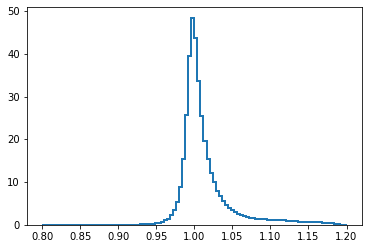

In [15]:
import matplotlib.pyplot as plt

df["wei"] = df["mcwei"] * df["genwei"] * df["puwei"]
weights = df["wei"].to_numpy()

binContent, binEdge, _ = plt.hist(preds, bins=100, range=(0.8, 1.2), histtype="step", weights=weights, linewidth=2)

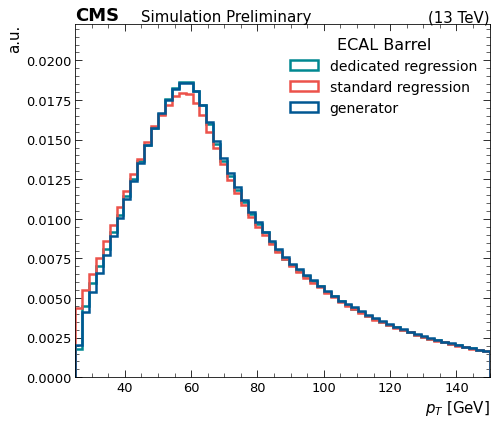

In [16]:
def pltSty(ax, xName="x-axis", yName="y-axis", TitleSize=15, LabelSize=15, TickSize=13, yAuto=True):
    from matplotlib.ticker import AutoLocator, AutoMinorLocator
    ax.set_xlabel(xName, fontsize=LabelSize, loc="right")
    ax.set_ylabel(yName, fontsize=LabelSize, loc="top")
    ax.text(1, 1, "(13 TeV)", horizontalalignment="right", verticalalignment="bottom", transform=ax.transAxes, fontsize=TitleSize)
    ax.text(0, 1, "CMS", horizontalalignment="left", verticalalignment="bottom", transform=ax.transAxes, fontsize=TitleSize * 1.2, fontweight="bold")
    ax.text(TitleSize * 0.009 + 0.025, 1, "Simulation Preliminary", horizontalalignment="left", verticalalignment="bottom", transform=ax.transAxes, fontsize=TitleSize)

    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    if (yAuto):
        ax.yaxis.set_major_locator(AutoLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(direction="in", length=7, labelsize=TickSize, top=True, right=True)
    ax.tick_params(direction="in", length=4, which="minor", labelsize=TickSize, top=True, right=True)


df["eleHDALRegPt_Lead"] = preds * df["elePt_Lead"]
df[["genPt", "elePt_Lead", "eleHDALRegPt_Lead"]]

fig, ax = plt.subplots(figsize=(7, 6))
pltSty(ax, xName="$p_{T}$ [GeV]", yName="a.u.")
# ax.set_yscale("log")

reg_out = "ECAL Barrel" if (iBE == 0) else "ECAL Endcap"
binContent, binEdge, _ = plt.hist(df["eleHDALRegPt_Lead"], bins=60, range=(25, 150), histtype="step", density=True, color="#008891", linewidth=2.5, label="dedicated regression")
binContent, binEdge, _ = plt.hist(df["elePt_Lead"],        bins=60, range=(25, 150), histtype="step", density=True, color="#EC524B", linewidth=2.5, label="standard regression")
binContent, binEdge, _ = plt.hist(df["genPt"],             bins=60, range=(25, 150), histtype="step", density=True, color="#005792", linewidth=2.5, label="generator")
plt.legend(loc="best", fontsize=14, edgecolor="none", title=reg_out, title_fontsize=16)
plt.tight_layout()
plt.ylim([0, max(binContent)*1.2])
plt.xlim([25, 150])

directory = "../plots/validation/pt_dist"
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig("{}/pt_distribution_{}.pdf".format(directory, region), bbox_inches="tight")

In [17]:
df["resp_XGB"] = df["eleHDALRegPt_Lead"]/df["genPt"]
df["resp_EGM"] = df["elePt_Lead"]/df["genPt"]

genPt = df["genPt"].to_numpy()
resp_XGB = df["resp_XGB"].to_numpy()
resp_EGM = df["resp_EGM"].to_numpy()

bins = 350 if iBE == 0 else 350
hist2D_XGB = ROOT.TH2D("hist2D_XGB", "", 13, 25, 155, bins, 0, 2)
hist2D_EGM = ROOT.TH2D("hist2D_EGM", "", 13, 25, 155, bins, 0, 2)

for i in range(len(resp_XGB)):
    hist2D_XGB.Fill(genPt[i], resp_XGB[i], weights[i])
    hist2D_EGM.Fill(genPt[i], resp_EGM[i], weights[i])
    
hist2D_XGB.Print("all")

TH1.Print Name  = hist2D_XGB, Entries= 9984651, Total sum= 370.124
 fSumw[0][0]=0, x=20, y=-0.00285714, error=0
 fSumw[1][0]=0, x=30, y=-0.00285714, error=0
 fSumw[2][0]=0, x=40, y=-0.00285714, error=0
 fSumw[3][0]=0, x=50, y=-0.00285714, error=0
 fSumw[4][0]=0, x=60, y=-0.00285714, error=0
 fSumw[5][0]=0, x=70, y=-0.00285714, error=0
 fSumw[6][0]=0, x=80, y=-0.00285714, error=0
 fSumw[7][0]=0, x=90, y=-0.00285714, error=0
 fSumw[8][0]=0, x=100, y=-0.00285714, error=0
 fSumw[9][0]=0, x=110, y=-0.00285714, error=0
 fSumw[10][0]=0, x=120, y=-0.00285714, error=0
 fSumw[11][0]=0, x=130, y=-0.00285714, error=0
 fSumw[12][0]=0, x=140, y=-0.00285714, error=0
 fSumw[13][0]=0, x=150, y=-0.00285714, error=0
 fSumw[14][0]=0, x=160, y=-0.00285714, error=0
 fSumw[0][1]=0, x=20, y=0.00285714, error=0
 fSumw[1][1]=0, x=30, y=0.00285714, error=0
 fSumw[2][1]=0, x=40, y=0.00285714, error=0
 fSumw[3][1]=0, x=50, y=0.00285714, error=0
 fSumw[4][1]=0, x=60, y=0.00285714, error=0
 fSumw[5][1]=0, x=70, y=0.

Warning in <TROOT::Append>: Replacing existing TH1: hist2D_XGB (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist2D_EGM (Potential memory leak).


In [18]:
def fit_resp(hist, pt_do, pt_up, method):
    # build fitting pdf
    x       = ROOT.RooRealVar("x", " ", 0, 2)
    mu      = ROOT.RooRealVar("mu",   " ",  hist.GetBinCenter(hist.GetMaximumBin()), 0.95, 1.05)
    sigma   = ROOT.RooRealVar("sigma",  " ", hist.GetStdDev(), 0.0, 0.5)
    alpha1  = ROOT.RooRealVar("alpha1", " ", 1,   1e-1,   3)
    alpha2  = ROOT.RooRealVar("alpha2", " ", 1,   1e-1,   3)
    n1      = ROOT.RooRealVar("n1",     " ", 80,    1,     200)
    n2      = ROOT.RooRealVar("n2",     " ", 80,    1,     200)
    pdf     = ROOT.RooCrystalBall("dcb", "dcb", x, mu, sigma, alpha1, n1, alpha2, n2)
    
    # histogram to be fitted
    dh = ROOT.RooDataHist("dh", "dh", x, ROOT.RooFit.Import(hist))
    x.setRange("fitRange", 0.65, 1.35)
    for i in range(10):
        results = pdf.fitTo(
            dh, 
            ROOT.RooFit.Minimizer("Minuit2", "minimize"),
            ROOT.RooFit.Range("fitRange"),
            ROOT.RooFit.Save(1), ROOT.RooFit.Strategy(2),
            ROOT.RooFit.SumW2Error(1), 
            ROOT.RooFit.PrintLevel(1)
        )
        if results.status() == 0:
            print(color.YELLOW + "Fitting succeed!" + color.END)
            break
    if results.status() != 0:
        print(color.RED + "Fitting failed after 10 trials!" + color.END)
        
    # visualization
    canv = ROOT.TCanvas("canv", "", 800, 650)
    canv.cd()
    canv.SetRightMargin(0.04)
    canv.SetTopMargin(0.075)
    canv.SetLeftMargin(0.14)
    canv.SetBottomMargin(0.14)

    xframe = x.frame(0.65, 1.35)
    dh.plotOn(
        xframe,
        RooFit.Name("hist"),
        # RooFit.Binning(nbins),
        RooFit.MarkerStyle(ROOT.kFullCircle), RooFit.MarkerSize(1.2),
        RooFit.LineWidth(2)
    )
    pdf.plotOn(
        xframe,
        RooFit.Name("pdf"),
        # RooFit.NormRange("NormRange"),
        RooFit.LineColor(ROOT.kRed - 4), RooFit.LineWidth(2)
    )
    dh.plotOn(
        xframe,
        RooFit.Name("hist"),
        # RooFit.Binning(nbins),
        RooFit.MarkerStyle(ROOT.kFullCircle), RooFit.MarkerSize(1.2),
        RooFit.LineWidth(2)
    )
    xframe.SetTitle("")
    xframe.GetXaxis().SetTitleSize(0.047)
    xframe.GetXaxis().SetLabelSize(0.046)
    xframe.GetXaxis().SetTitleOffset(1.24)
    xframe.GetXaxis().SetLabelOffset(0.012)
    xframe.GetXaxis().SetTitle("p^{reco}_{T} / p^{true}_{T}")
    # xframe.GetYaxis().SetTitle("Events / 0.005")
    xframe.GetYaxis().SetTitleSize(0.047)
    xframe.GetYaxis().SetLabelSize(0.046)
    xframe.GetYaxis().SetTitleOffset(1.4)
    xframe.SetMaximum(xframe.GetMaximum() * 1.5)
    xframe.SetMinimum(0)
    xframe.Draw()
    
    leg = ROOT.TLegend(0.17, 0.64, 0.45, 0.76)
    leg.SetTextFont(42)
    leg.SetTextSize(0.04)
    leg.SetFillColor(0)
    leg.SetLineColor(0)
    leg.AddEntry(xframe.findObject("hist"), "Simulation", "LE1P")
    leg.AddEntry(xframe.findObject("pdf"), "DCB", "l")
    leg.Draw("same")

    var1 = results.floatParsFinal().find("mu")
    var2 = results.floatParsFinal().find("sigma")
    ltx = ROOT.TLatex()
    ltx.SetNDC()
    ltx.SetTextFont(42)
    ltx.SetTextSize(0.045)
    ltx.DrawLatex(0.58, 0.86, " #mu = %.4f #pm %.4f" %(var1.getValV(), var1.getError()))
    ltx.DrawLatex(0.58, 0.81, " #sigma = %.4f #pm %.4f" %(var2.getValV(), var2.getError()))
    
    region = "ECAL Barrrel" if iBE == 0 else "ECAL Endcap"
    ltx.DrawLatex(0.18, 0.58, "%d < p^{true}_{T} < %d GeV" %(pt_do, pt_up))
    ltx.DrawLatex(0.18, 0.5, region)
    
    CMS_lumi(canv, 5, 10, "", 2017, True, "Simulation Preliminary", "H #rightarrow #gamma* #gamma #rightarrow ee#gamma", "")
    canv.Update()
    canv.RedrawAxis()

    reg_ext = "EB" if iBE == 0 else "EE"
    directory = "../plots/validation/resp_fit/{}".format(reg_ext)
    if not os.path.exists(directory):
        os.makedirs(directory)
    canv.Print("{}/respFit_pt_{}_{}To{}GeV.pdf".format(directory, method, int(pt_do), int(pt_up)))
    canv.Close()
    
    return results

In [19]:
x_mu, y_mu, xerr_mu, yerr_mu = [], [], [], []
x_width, y_width, xerr_width, yerr_width = [], [], [], []
for i in range(hist2D_XGB.GetNbinsX()):
# for i in range(1):
    pt_do = hist2D_XGB.GetXaxis().GetBinLowEdge(i+1) 
    pt_up = hist2D_XGB.GetXaxis().GetBinUpEdge(i+1)
    print(color.GREEN + "[INFO] Perform the fitting in range [%d, %d]" %(int(pt_do), int(pt_up)) + color.END)
    histName_XGB = "hist1D_XGB_{}To{}".format(pt_do, pt_up)
    hist_XGB = hist2D_XGB.ProjectionY(histName_XGB, i+1, i+1).Clone()
    fitRes = fit_resp(hist_XGB, pt_do, pt_up, "XGB")
    fitRes.Print("V")
    
    x_mu.append(pt_do+(pt_up-pt_do)/2)
    y_mu.append(fitRes.floatParsFinal().find("mu").getValV())
    xerr_mu.append((pt_up-pt_do)/2)
    yerr_mu.append(fitRes.floatParsFinal().find("mu").getError())
    
    sigma_ave = fitRes.floatParsFinal().find("sigma").getValV()
    sigma_ave_err = fitRes.floatParsFinal().find("sigma").getError()
    x_width.append(pt_do+(pt_up-pt_do)/2)
    y_width.append(sigma_ave)
    xerr_width.append((pt_up-pt_do)/2)
    yerr_width.append(sigma_ave_err)
    
mu_err_XGB = ROOT.TGraphErrors(hist2D_XGB.GetNbinsX(), np.array(x_mu), np.array(y_mu), np.array(xerr_mu), np.array(yerr_mu)) 
width_err_XGB = ROOT.TGraphErrors(hist2D_XGB.GetNbinsX(), np.array(x_width), np.array(y_width), np.array(xerr_width), np.array(yerr_width)) 
width_err_XGB.Print()

[INFO] Perform the fitting in range [25, 35]
Fitting succeed!
[INFO] Perform the fitting in range [35, 45]
Fitting succeed!
[INFO] Perform the fitting in range [45, 55]
Fitting succeed!
[INFO] Perform the fitting in range [55, 65]
Fitting succeed!
[INFO] Perform the fitting in range [65, 75]
Fitting succeed!
[INFO] Perform the fitting in range [75, 85]
Fitting succeed!
[INFO] Perform the fitting in range [85, 95]
Fitting succeed!
[INFO] Perform the fitting in range [95, 105]
Fitting succeed!
[INFO] Perform the fitting in range [105, 115]
Fitting succeed!
[INFO] Perform the fitting in range [115, 125]
Fitting succeed!
[INFO] Perform the fitting in range [125, 135]
Fitting succeed!
[INFO] Perform the fitting in range [135, 145]
Fitting succeed!
[INFO] Perform the fitting in range [145, 155]
Fitting succeed!
[#0] WARNING:InputArguments -- The parameter 'sigma' with range [0, 0.5] of the RooCrystalBall 'dcb' exceeds the safe range of (0, inf). Advise to limit its range.
[#1] INFO:Eval -- R

Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_XGB_25To35GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_XGB_35To45GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_XGB_45To55GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_XGB_55To65GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_XGB_65To75GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_XGB_75To85GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_XGB_85To95GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_XGB_95To105GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_XGB_105To115GeV.p

In [20]:
x_mu_egm, y_mu_egm, xerr_mu_egm, yerr_mu_egm = [], [], [], []
x_width_egm, y_width_egm, xerr_width_egm, yerr_width_egm = [], [], [], []
for i in range(hist2D_EGM.GetNbinsX()):
    pt_do = hist2D_EGM.GetXaxis().GetBinLowEdge(i+1) 
    pt_up = hist2D_EGM.GetXaxis().GetBinUpEdge(i+1)
    print(color.GREEN + "[INFO] Perform the fitting in range [%d, %d]" %(int(pt_do), int(pt_up)) + color.END)
    histName_EGM = "hist1D_EGM_{}To{}".format(pt_do, pt_up) 
    hist_EGM = hist2D_EGM.ProjectionY(histName_EGM, i+1, i+1).Clone()
    fitRes = fit_resp(hist_EGM, pt_do, pt_up, "EGM")
    fitRes.Print("V")
    
    x_mu_egm.append(pt_do+(pt_up-pt_do)/2)
    y_mu_egm.append(fitRes.floatParsFinal().find("mu").getValV())
    xerr_mu_egm.append((pt_up-pt_do)/2)
    yerr_mu_egm.append(fitRes.floatParsFinal().find("mu").getError())
    
    sigma_ave = fitRes.floatParsFinal().find("sigma").getValV()
    sigma_ave_err = fitRes.floatParsFinal().find("sigma").getError()
    x_width_egm.append(pt_do+(pt_up-pt_do)/2)
    y_width_egm.append(sigma_ave)
    xerr_width_egm.append((pt_up-pt_do)/2)
    yerr_width_egm.append(sigma_ave_err)
    
mu_err_EGM = ROOT.TGraphErrors(hist2D_EGM.GetNbinsX(), np.array(x_mu_egm), np.array(y_mu_egm), np.array(xerr_mu_egm), np.array(yerr_mu_egm)) 
width_err_EGM = ROOT.TGraphErrors(hist2D_EGM.GetNbinsX(), np.array(x_width_egm), np.array(y_width_egm), np.array(xerr_width_egm), np.array(yerr_width_egm)) 
width_err_EGM.Print()

[INFO] Perform the fitting in range [25, 35]
Fitting succeed!
[INFO] Perform the fitting in range [35, 45]
Fitting succeed!
[INFO] Perform the fitting in range [45, 55]
Fitting succeed!
[INFO] Perform the fitting in range [55, 65]
Fitting succeed!
[INFO] Perform the fitting in range [65, 75]
Fitting succeed!
[INFO] Perform the fitting in range [75, 85]
Fitting succeed!
[INFO] Perform the fitting in range [85, 95]
Fitting succeed!
[INFO] Perform the fitting in range [95, 105]
Fitting succeed!
[INFO] Perform the fitting in range [105, 115]
Fitting succeed!
[INFO] Perform the fitting in range [115, 125]
Fitting succeed!
[INFO] Perform the fitting in range [125, 135]
Fitting succeed!
[INFO] Perform the fitting in range [135, 145]
Fitting succeed!
[INFO] Perform the fitting in range [145, 155]
Fitting succeed!
[#0] WARNING:InputArguments -- The parameter 'sigma' with range [0, 0.5] of the RooCrystalBall 'dcb' exceeds the safe range of (0, inf). Advise to limit its range.
[#1] INFO:Eval -- R

Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_EGM_25To35GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_EGM_35To45GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_EGM_45To55GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_EGM_55To65GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_EGM_65To75GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_EGM_75To85GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_EGM_85To95GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_EGM_95To105GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit/EB/respFit_pt_EGM_105To115GeV.p

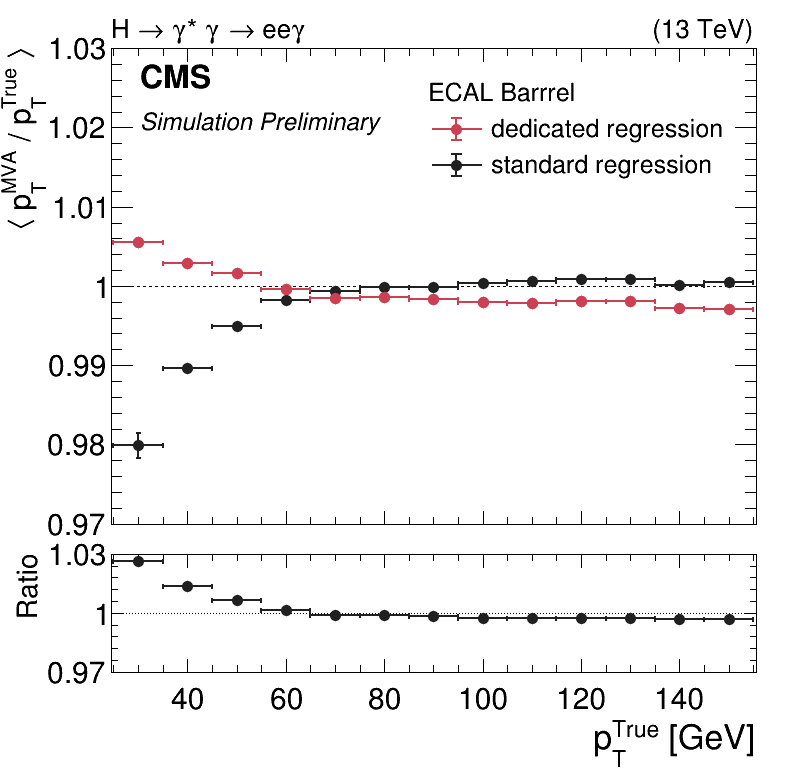

In [21]:
c1 = ROOT.TCanvas("c1", "", 800, 800)
c1.cd()

pad1 = ROOT.TPad("pad1", " ", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.03)
pad1.SetTopMargin(0.09)
pad1.SetRightMargin(0.05)
pad1.SetLeftMargin(0.14)
pad1.Draw()
pad1.cd()

mu_err_XGB.GetXaxis().SetTitle("")
mu_err_XGB.GetYaxis().SetTitle("#LT p^{MVA}_{T} / p^{True}_{T} #GT")
mu_err_XGB.GetYaxis().SetRangeUser(0.97, 1.03)
mu_err_XGB.GetYaxis().SetNdivisions(506)
mu_err_XGB.GetYaxis().SetTickSize(0.03)
mu_err_XGB.GetYaxis().SetTitleSize(0.06)
mu_err_XGB.GetYaxis().SetLabelSize(0.06)
mu_err_XGB.GetYaxis().SetTitleOffset(1.15)

mu_err_XGB.GetXaxis().SetRangeUser(25, 155)
mu_err_XGB.GetXaxis().SetTickSize(0.03)
mu_err_XGB.GetXaxis().SetTitleSize(0.06)
mu_err_XGB.GetXaxis().SetLabelSize(0.05)
mu_err_XGB.GetXaxis().SetLabelOffset(0.1)
mu_err_XGB.GetXaxis().SetTitleOffset(1)
mu_err_XGB.SetMarkerColor(ROOT.TColor.GetColor("#CC4054"))
mu_err_XGB.SetMarkerSize(1.4)
mu_err_XGB.SetMarkerStyle(20)
mu_err_XGB.SetLineColor(ROOT.TColor.GetColor("#CC4054"))
mu_err_XGB.SetLineWidth(2)
mu_err_XGB.Draw("AP")

mu_err_EGM.SetMarkerColor(ROOT.TColor.GetColor("#202020"))
mu_err_EGM.SetMarkerSize(1.4)
mu_err_EGM.SetMarkerStyle(20)
mu_err_EGM.SetLineColor(ROOT.TColor.GetColor("#202020"))
mu_err_EGM.SetLineWidth(2)

l = ROOT.TLine(25, 1, 155, 1)
l.SetLineStyle(2)
l.SetLineColor(1)
l.Draw()

mu_err_EGM.Draw("P same")
mu_err_XGB.Draw("P same")

region = "ECAL Barrrel" if iBE == 0 else "ECAL Endcap"
leg = ROOT.TLegend(0.53, 0.66, 0.88, 0.86)
leg.SetHeader(region)
leg.SetTextFont(42)
leg.SetTextSize(0.05)
leg.SetFillColor(0)
leg.SetLineColor(0)
leg.AddEntry(mu_err_XGB, "dedicated regression", "LE1P")
leg.AddEntry(mu_err_EGM, "standard regression", "LE1P")
leg.Draw("same")

CMS_lumi(pad1, 5, 10, "", 2017, True, "Simulation Preliminary", "H #rightarrow #gamma* #gamma #rightarrow ee#gamma", "")
c1.cd()

pad2 = ROOT.TPad("pad2", "", 0, 0, 1, 0.3)
pad2.SetGridy()
pad2.SetRightMargin(0.05)
pad2.SetLeftMargin(0.14)
pad2.SetTopMargin(0.06)
pad2.SetBottomMargin(0.43)
pad2.Draw()
pad2.cd()

nPoints = mu_err_XGB.GetN()
ratio_err = ROOT.TGraphErrors(nPoints)
for i in range(nPoints):
    xp = mu_err_XGB.GetPointX(i)
    yp = mu_err_XGB.GetPointY(i)/mu_err_EGM.GetPointY(i)
    xp_err = mu_err_XGB.GetErrorX(i)
    yp_err = yp * np.sqrt(pow(mu_err_XGB.GetErrorY(i)/mu_err_XGB.GetPointY(i), 2) + pow(mu_err_EGM.GetErrorY(i)/mu_err_EGM.GetPointY(i), 2))
    
    ratio_err.SetPoint(i, xp, yp)
    ratio_err.SetPointError(i, xp_err, yp_err)

ratio_err.SetName("")
ratio_err.SetTitle("")
ratio_err.GetXaxis().SetTitle("p^{True}_{T} [GeV]")
ratio_err.GetYaxis().SetTitle("Ratio")
ratio_err.GetYaxis().SetRangeUser(0.97 , 1.03)

ratio_err.SetMarkerColor(ROOT.TColor.GetColor("#202020"))
ratio_err.SetMarkerSize(1.4)
ratio_err.SetMarkerStyle(20)
ratio_err.SetLineColor(ROOT.TColor.GetColor("#202020"))
ratio_err.SetLineWidth(2)

ratio_err.GetXaxis().SetRangeUser(25, 155)
ratio_err.GetXaxis().SetTickSize(0.03 * (7/3.))
ratio_err.GetXaxis().SetTitleSize(0.16)
ratio_err.GetXaxis().SetTitleOffset(1.2)
ratio_err.GetXaxis().SetLabelSize(0.06  * (7/3.))
ratio_err.GetXaxis().SetLabelOffset(0.05)
ratio_err.GetYaxis().SetTitleSize(0.13)
ratio_err.GetYaxis().SetTitleOffset(0.22 * (7/3.))
ratio_err.GetYaxis().SetLabelSize(0.06  * (7/3.))
ratio_err.GetYaxis().SetNdivisions(502)
ratio_err.Draw("AP")

c1.Draw()

In [22]:
reg_ext = "EB" if iBE == 0 else "EE"
directory = "../plots/validation/resp_mu"
if not os.path.exists(directory):
    os.makedirs(directory)

c1.Print("{}/respMu_pt_{}.pdf".format(directory, reg_ext))
c1.Close()

Info in <TCanvas::Print>: pdf file ../plots/validation/resp_mu/respMu_pt_EB.pdf has been created


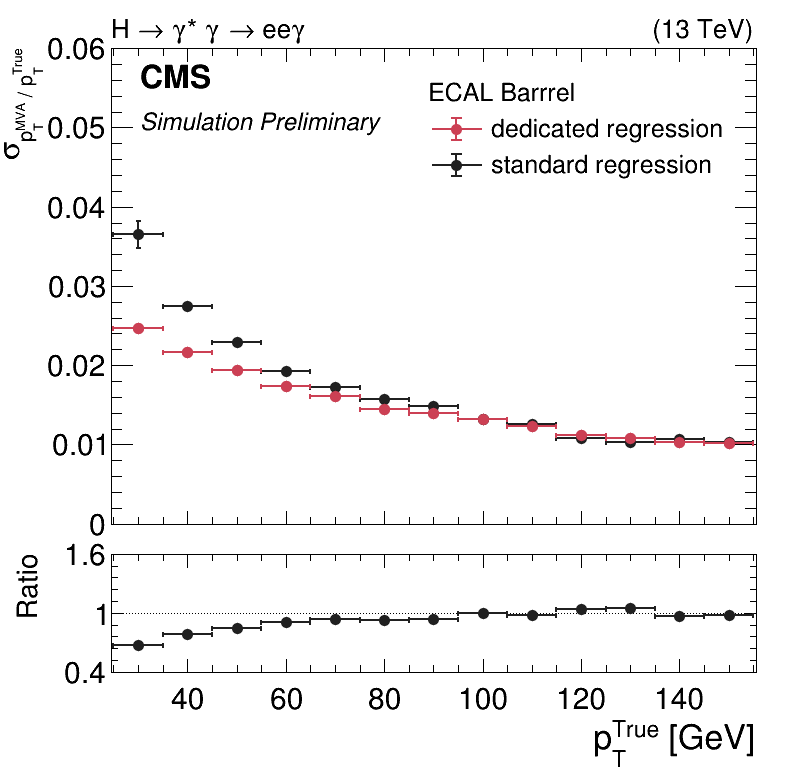

In [23]:
c1 = ROOT.TCanvas("c1", "", 800, 800)
c1.cd()

pad1 = ROOT.TPad("pad1", " ", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.03)
pad1.SetTopMargin(0.09)
pad1.SetRightMargin(0.05)
pad1.SetLeftMargin(0.14)
pad1.Draw()
pad1.cd()

width_err_XGB.GetXaxis().SetTitle("")
width_err_XGB.GetYaxis().SetTitle("#sigma_{p^{MVA}_{T} / p^{True}_{T}}")
width_err_XGB.GetYaxis().SetRangeUser(0, 0.06)
width_err_XGB.GetYaxis().SetNdivisions(506)
width_err_XGB.GetYaxis().SetTickSize(0.03)
width_err_XGB.GetYaxis().SetTitleSize(0.06)
width_err_XGB.GetYaxis().SetLabelSize(0.06)
width_err_XGB.GetYaxis().SetTitleOffset(1.15)

width_err_XGB.GetXaxis().SetRangeUser(25, 155)
width_err_XGB.GetXaxis().SetTickSize(0.03)
width_err_XGB.GetXaxis().SetTitleSize(0.06)
width_err_XGB.GetXaxis().SetLabelSize(0.05)
width_err_XGB.GetXaxis().SetLabelOffset(0.1)
width_err_XGB.GetXaxis().SetTitleOffset(1)
width_err_XGB.SetMarkerColor(ROOT.TColor.GetColor("#CC4054"))
width_err_XGB.SetMarkerSize(1.4)
width_err_XGB.SetMarkerStyle(20)
width_err_XGB.SetLineColor(ROOT.TColor.GetColor("#CC4054"))
width_err_XGB.SetLineWidth(2)
width_err_XGB.Draw("AP")

width_err_EGM.SetMarkerColor(ROOT.TColor.GetColor("#202020"))
width_err_EGM.SetMarkerSize(1.4)
width_err_EGM.SetMarkerStyle(20)
width_err_EGM.SetLineColor(ROOT.TColor.GetColor("#202020"))
width_err_EGM.SetLineWidth(2)

# l = ROOT.TLine(25, 1, 155, 1)
# l.SetLineStyle(2)
# l.SetLineColor(1)
# l.Draw()
    
width_err_EGM.Draw("P same")
width_err_XGB.Draw("P same")

region = "ECAL Barrrel" if iBE == 0 else "ECAL Endcap"
leg = ROOT.TLegend(0.53, 0.66, 0.88, 0.86)
leg.SetHeader(region)
leg.SetTextFont(42)
leg.SetTextSize(0.05)
leg.SetFillColor(0)
leg.SetLineColor(0)
leg.AddEntry(mu_err_XGB, "dedicated regression", "LE1P")
leg.AddEntry(mu_err_EGM, "standard regression", "LE1P")
leg.Draw("same")

CMS_lumi(pad1, 5, 10, "", 2017, True, "Simulation Preliminary", "H #rightarrow #gamma* #gamma #rightarrow ee#gamma", "")
c1.cd()

pad2 = ROOT.TPad("pad2", "", 0, 0, 1, 0.3)
pad2.SetGridy()
pad2.SetRightMargin(0.05)
pad2.SetLeftMargin(0.14)
pad2.SetTopMargin(0.06)
pad2.SetBottomMargin(0.43)
pad2.Draw()
pad2.cd()

nPoints = width_err_XGB.GetN()
ratio_err = ROOT.TGraphErrors(nPoints)
for i in range(nPoints):
    xp = width_err_XGB.GetPointX(i)
    yp = width_err_XGB.GetPointY(i)/width_err_EGM.GetPointY(i)
    xp_err = width_err_XGB.GetErrorX(i)
    yp_err = yp * np.sqrt(pow(width_err_XGB.GetErrorY(i)/width_err_XGB.GetPointY(i), 2) + pow(width_err_EGM.GetErrorY(i)/width_err_EGM.GetPointY(i), 2))
    
    ratio_err.SetPoint(i, xp, yp)
    ratio_err.SetPointError(i, xp_err, yp_err)

ratio_err.SetName("")
ratio_err.SetTitle("")
ratio_err.GetXaxis().SetTitle("p^{True}_{T} [GeV]")
ratio_err.GetYaxis().SetTitle("Ratio")
ratio_err.GetYaxis().SetRangeUser(0.4 , 1.6)

ratio_err.SetMarkerColor(ROOT.TColor.GetColor("#202020"))
ratio_err.SetMarkerSize(1.4)
ratio_err.SetMarkerStyle(20)
ratio_err.SetLineColor(ROOT.TColor.GetColor("#202020"))
ratio_err.SetLineWidth(2)

ratio_err.GetXaxis().SetRangeUser(25, 155)
ratio_err.GetXaxis().SetTickSize(0.03 * (7/3.))
ratio_err.GetXaxis().SetTitleSize(0.16)
ratio_err.GetXaxis().SetTitleOffset(1.2)
ratio_err.GetXaxis().SetLabelSize(0.06  * (7/3.))
ratio_err.GetXaxis().SetLabelOffset(0.05)
ratio_err.GetYaxis().SetTitleSize(0.13)
ratio_err.GetYaxis().SetTitleOffset(0.22 * (7/3.))
ratio_err.GetYaxis().SetLabelSize(0.06  * (7/3.))
ratio_err.GetYaxis().SetNdivisions(502)
ratio_err.Draw("AP")

c1.Draw()

In [24]:
reg_ext = "EB" if iBE == 0 else "EE"
directory = "../plots/validation/resp_width"
if not os.path.exists(directory):
    os.makedirs(directory)
c1.Print("{}/respWidth_pt_{}.pdf".format(directory, reg_ext))
c1.Close()

Info in <TCanvas::Print>: pdf file ../plots/validation/resp_width/respWidth_pt_EB.pdf has been created
